202007Gp2 bloom timing

In [51]:
import datetime as dt
from erddapy import ERDDAP
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr

from salishsea_tools import places

%matplotlib inline

### Set up Model Results Getting

In [52]:
directory = '202007G-p2'
dir_path = Path(f"/data/sallen/results/MEOPAR/202007/{directory}")

In [53]:
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "nav_lat",
    "bounds_lat",
    "nav_lon",
    "bounds_lon",
    "area",
    "deptht_bounds",
]
chunks = {
    "time_counter": 1,
    "deptht": 1,
}

In [54]:
def prep_timeseries(dir_path, file_pattern, n_days): 
    ds_files = sorted(dir_path.glob(file_pattern))
    ds = xr.open_mfdataset(
        ds_files[:n_days],
        chunks=chunks,
        drop_variables=drop_vars,
    )
    S3y, S3x = places.PLACES['S3']['NEMO grid ji'][0], places.PLACES['S3']['NEMO grid ji'][1]
    fourkm = 8
    timeseries = ds.isel(deptht = 1, y = slice(S3y-fourkm, S3y+fourkm+1), 
                             x =  slice(S3x-fourkm, S3x+fourkm+1))
    
    return timeseries

### Set up Observations Getting

In [55]:
server = "https://salishsea.eos.ubc.ca/erddap"

protocol = "tabledap"

dataset_id = "ubcONCTWDP1mV18-01"

response = "nc"

variables = [
    "latitude",
    "longitude",
    "chlorophyll",
    "o2_concentration_corrected",
    "time",
]

variables2 = [
    "latitude",
    "longitude",
    "o2_concentration_corrected",
    "time",
]

    

fourkmlat = 4/110.574
fourkmlon = 4/(111.320*np.cos(50*np.pi/180.))
lon, lat = places.PLACES['S3']['lon lat']

### Plotting Functions

In [56]:
def model_plot(timeseries2015):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            timeseries2015.diatoms[:, j, i].plot(ax=axs[0], color='blue', marker='o')
            timeseries2015.diatoms[:, j, i].plot(ax=axs[1], color='blue', marker='o')
    ax2 = axs[0].twinx()
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            timeseries2015.nitrate[:, j, i].plot(ax=ax2, color='lightblue', marker='o')
    axs[0].grid()
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            (timeseries2015.diatoms+timeseries2015.flagellates+timeseries2015.ciliates)[:, j, i].plot(ax=axs[1], color='purple', marker='o', alpha=0.5);

In [57]:
def model_obs_comparison(timeseries2015, obs_pd, N2Chl=2.5, oxy=False):
    fig, axs = plt.subplots(1, 1, figsize=(7, 4))
    if oxy:
        ax2 = axs
        ax = ax2.twinx()
        obs_pd['o2_concentration_corrected (ml/l)'].plot(ax=ax2, marker='o', color='lime', linewidth=0, alpha=0.4, zorder=6);
    else:
        ax = axs
        obs_pd['chlorophyll (ug/l)'].plot(ax=ax, marker='o', color='green', linewidth=0, zorder=2)
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            ((timeseries2015.diatoms+timeseries2015.flagellates+timeseries2015.ciliates)[:, j, i]*N2Chl).plot(ax=ax, color='purple', 
                                                                                                              marker='.', alpha=0.5, linewidth=0, zorder=3);


# 2015

## Model Results

In [58]:
year = 2015
months_regex = '0[23]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [59]:
timeseries.load(scheduler='processes', num_workers=4);

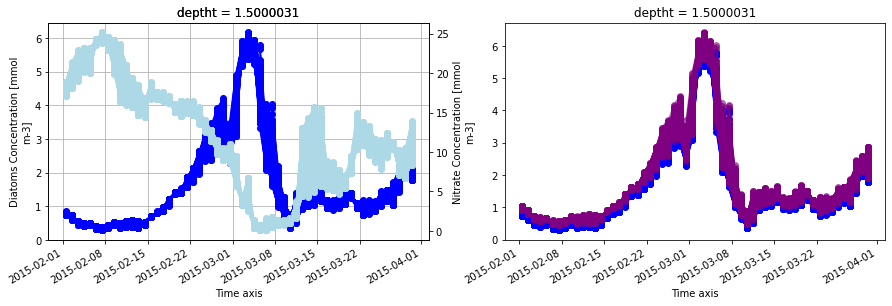

In [60]:
model_plot(timeseries)

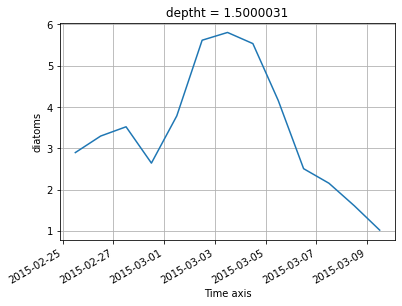

In [61]:
timeseries.diatoms[28-4:28-1+10].mean(axis=1).mean(axis=1).plot();
plt.grid()

Bloom is March 3.  This bloom is six days early.

## Observations

In [62]:
constraints = {
    "time>=": "2015-02-01T00:00:00Z",
    "time<=": "2015-04-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}

In [63]:
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [64]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,)

In [65]:
obs_pd

,latitude (degrees_north),longitude (degrees_east),chlorophyll (ug/l),o2_concentration_corrected (ml/l)
time (UTC),,,,
2015-02-01 00:04:00+00:00,49.148050,-123.610267,NaN,7.996494
2015-02-01 00:05:00+00:00,49.145050,-123.603717,NaN,8.007871
2015-02-01 00:06:00+00:00,49.141983,-123.597183,NaN,8.018316
2015-02-01 00:07:00+00:00,49.138950,-123.590683,NaN,7.999234
2015-02-01 00:08:00+00:00,49.135883,-123.584117,NaN,7.993195
...,...,...,...,...
2015-03-31 23:23:00+00:00,49.150683,-123.574283,NaN,NaN
2015-03-31 23:24:00+00:00,49.152933,-123.581150,NaN,NaN
2015-03-31 23:25:00+00:00,49.155250,-123.588017,NaN,NaN


In [66]:
obs2 = ERDDAP(server=server, protocol=protocol,)

obs2.dataset_id = dataset_id
obs2.variables = variables2
obs2.constraints = constraints

In [67]:
obs2_pd = obs2.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()
obs2_pd

,latitude (degrees_north),longitude (degrees_east),o2_concentration_corrected (ml/l)
time (UTC),,,
2015-02-01 00:04:00+00:00,49.148050,-123.610267,7.996494
2015-02-01 00:05:00+00:00,49.145050,-123.603717,8.007871
2015-02-01 00:06:00+00:00,49.141983,-123.597183,8.018316
2015-02-01 00:07:00+00:00,49.138950,-123.590683,7.999234
2015-02-01 00:08:00+00:00,49.135883,-123.584117,7.993195
...,...,...,...
2015-03-26 23:24:00+00:00,49.151150,-123.584750,7.900143
2015-03-26 23:25:00+00:00,49.153417,-123.591550,7.847942
2015-03-26 23:26:00+00:00,49.155717,-123.598400,7.779136


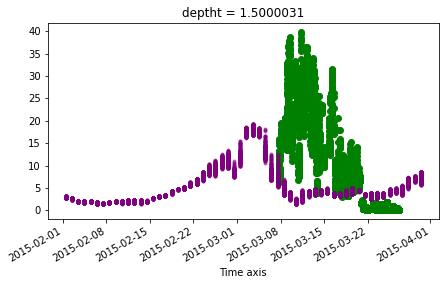

In [68]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3)

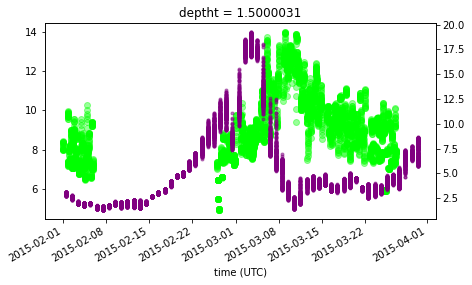

In [69]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3, oxy=True)

In [70]:
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean()

time (UTC)
2015-02-01 00:00:00+00:00          NaN
2015-02-02 00:00:00+00:00          NaN
2015-02-03 00:00:00+00:00          NaN
2015-02-04 00:00:00+00:00          NaN
2015-02-05 00:00:00+00:00          NaN
2015-02-06 00:00:00+00:00          NaN
2015-02-07 00:00:00+00:00          NaN
2015-02-08 00:00:00+00:00          NaN
2015-02-09 00:00:00+00:00          NaN
2015-02-10 00:00:00+00:00          NaN
2015-02-11 00:00:00+00:00          NaN
2015-02-12 00:00:00+00:00          NaN
2015-02-13 00:00:00+00:00          NaN
2015-02-14 00:00:00+00:00          NaN
2015-02-15 00:00:00+00:00          NaN
2015-02-16 00:00:00+00:00          NaN
2015-02-17 00:00:00+00:00          NaN
2015-02-18 00:00:00+00:00          NaN
2015-02-19 00:00:00+00:00          NaN
2015-02-20 00:00:00+00:00          NaN
2015-02-21 00:00:00+00:00          NaN
2015-02-22 00:00:00+00:00          NaN
2015-02-23 00:00:00+00:00          NaN
2015-02-24 00:00:00+00:00          NaN
2015-02-25 00:00:00+00:00          NaN
2015-02-26 00:

Bloom is March 9.

# 2016

## Model Results

In [71]:
year = 2016
months_regex = '0[34]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [72]:
timeseries.load(scheduler='processes', num_workers=4);

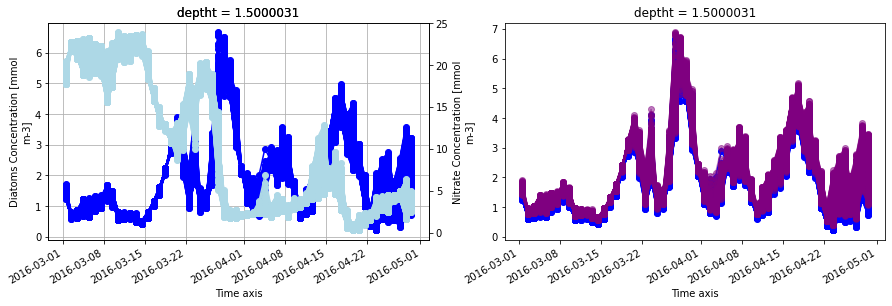

In [73]:
model_plot(timeseries)

In [74]:
timeseries.diatoms[20-1:32-1].mean(axis=1).mean(axis=1)

<xarray.DataArray 'diatoms' (time_counter: 12)>
array([3.4638798, 2.5917835, 1.5133893, 2.2933319, 1.2351433, 1.1160707,
       2.3066697, 4.2506437, 5.904618 , 5.0639   , 3.4722588, 2.152512 ],
      dtype=float32)
Coordinates:
    deptht        float32 1.5
  * time_counter  (time_counter) datetime64[ns] 2016-03-20T12:00:00 ... 2016-...

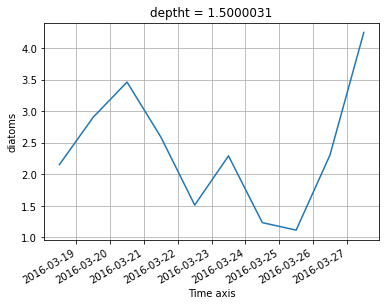

In [75]:
timeseries.diatoms[17:27].mean(axis=1).mean(axis=1).plot();
plt.grid()

Bloom date is March 28.  This value is only 4 days late.  Looks okay though, see below.

## Observations

In [76]:
constraints = {
    "time>=": "2016-03-01T00:00:00Z",
    "time<=": "2016-05-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}

In [77]:
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [78]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

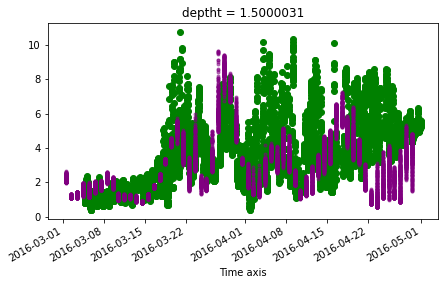

In [79]:
model_obs_comparison(timeseries, obs_pd, N2Chl=1.4)

In [80]:
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean()[20:29]

time (UTC)
2016-03-24 00:00:00+00:00    5.287270
2016-03-25 00:00:00+00:00    3.523971
2016-03-26 00:00:00+00:00    2.696661
2016-03-27 00:00:00+00:00    4.394448
2016-03-28 00:00:00+00:00    5.547918
2016-03-29 00:00:00+00:00    5.706081
2016-03-30 00:00:00+00:00    3.574641
2016-03-31 00:00:00+00:00    2.481376
2016-04-01 00:00:00+00:00    2.270905
Freq: D, Name: chlorophyll (ug/l), dtype: float64

Bloom date is March 24.

# 2017

## Model Results

In [81]:
year = 2017
months_regex = '0[234]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [82]:
timeseries.load(scheduler='processes', num_workers=4);

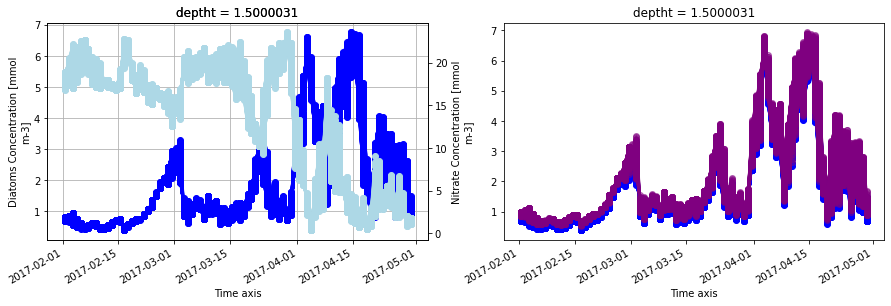

In [83]:
model_plot(timeseries)

In [84]:
timeseries.diatoms[32-1:42-1].mean(axis=1).mean(axis=1)

<xarray.DataArray 'diatoms' (time_counter: 10)>
array([0.8430651 , 1.0967275 , 1.2457079 , 1.1643604 , 0.850832  ,
       1.2122111 , 1.1259799 , 1.1903219 , 0.83626544, 0.89812803],
      dtype=float32)
Coordinates:
    deptht        float32 1.5
  * time_counter  (time_counter) datetime64[ns] 2017-03-04T12:00:00 ... 2017-...

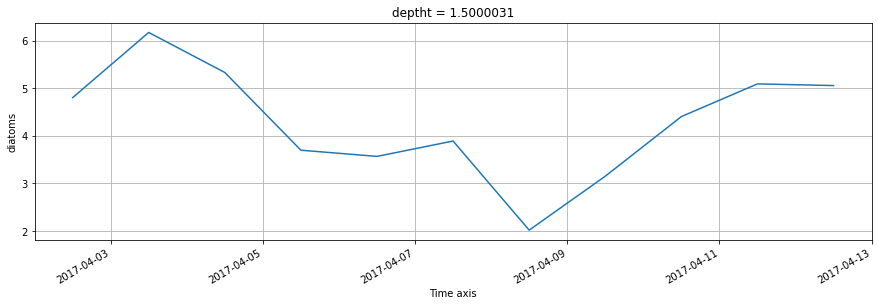

In [85]:
fig, ax =plt.subplots(1, 1, figsize=(15, 4))
timeseries.diatoms[60:71].mean(axis=1).mean(axis=1).plot(ax=ax);
ax.grid();

Split bloom.

## Observations

In [86]:
constraints = {
    "time>=": "2017-02-01T00:00:00Z",
    "time<=": "2017-05-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [87]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

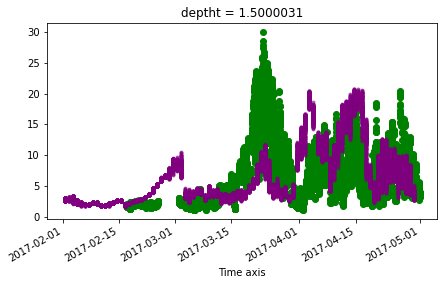

In [88]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3)

They all look pretty good.

In [89]:
# 2018

In [93]:
year = 2018
months_regex = '0[234]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [94]:
timeseries.load(scheduler='processes', num_workers=4);

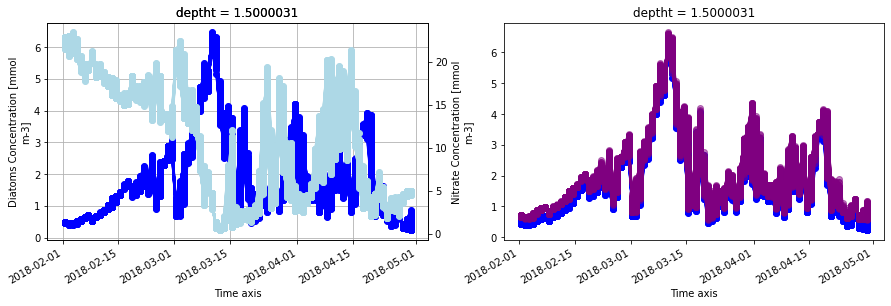

In [95]:
model_plot(timeseries)

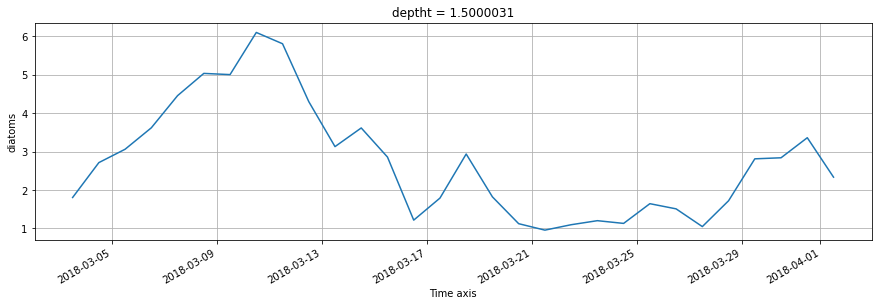

In [97]:
fig, ax =plt.subplots(1, 1, figsize=(15, 4))
timeseries.diatoms[30:60].mean(axis=1).mean(axis=1).plot(ax=ax);
ax.grid();

In [98]:
constraints = {
    "time>=": "2018-02-01T00:00:00Z",
    "time<=": "2018-05-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [99]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

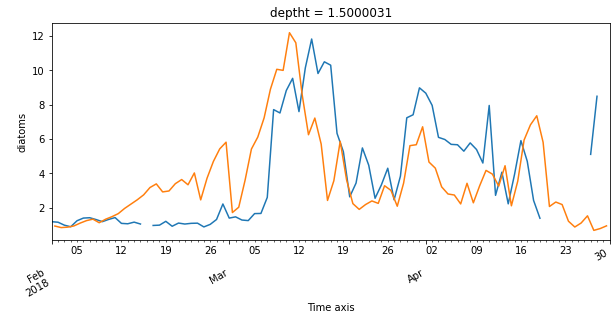

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean().plot(ax=ax);
(timeseries.diatoms.mean(axis=1).mean(axis=1)*2).plot(ax=ax,color=
                                                        'tab:orange');


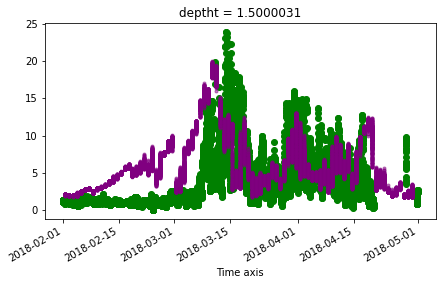

In [101]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3)